In [1]:
λ(x,y,z) = x^2+y^2+z^2-2x*y-2y*z-2z*x

λ (generic function with 1 method)

In [2]:
const mπ = 0.14; const mπ2 = mπ^2;

In [3]:
function g(s,σ)
    λλ = λ(s,σ,mπ2)*λ(σ,mπ2,mπ2)
    return λλ < 0 ? 0.0 : sqrt(λλ)/(s*σ)
end

g (generic function with 1 method)

In [4]:
function generate_rand2d(g, Nrows, Ncols)
    grid = hcat([[[si,σi] for σi=LinRange(4mπ2, (√si-mπ)^2, Nrows)] for si=LinRange(0.6^2, 5^2, Ncols)]...)
    #
    weights = [g(v...) for v in (grid[2:end,:] .+ grid[1:end-1,:]) ./ 2]
    # normalize by the cell size
    for i=1:size(grid,1)-1, j=1:size(grid,2)
        weights[i,j] *= grid[i+1,j][2] - grid[i,j][2]
    end
    weights ./= sum(weights)
    cumarr = [0;cumsum(vcat(weights...), dims=1)]
    function custom_rand()
        # get
        binind = findfirst(cumarr .> rand())-2
        # pars back
        indCol = div(binind, Nrows-1) + 1
        indRow = mod(binind, Nrows-1) + 1
        indRow+1 > Nrows && error("indRow+1 > Nrows: binind = $binind")
        indCol > Ncols && error("indCol > Ncols: binind = $binind")
        s1, σ1 = grid[indRow,indCol]
        s2, σ2 = grid[indRow+1,indCol]
        s1 != s2 && error("Something is wrong!")
        s = s1
        σ = σ1+rand()*(σ2-σ1)
        return [s, σ]
    end
    return custom_rand
end

generate_rand2d (generic function with 1 method)

In [25]:
dataset = let myr = generate_rand2d(g, 100, 5)
    hcat([myr() for i=1:100000]...)
end;

In [6]:
using Plots
using QuadGK

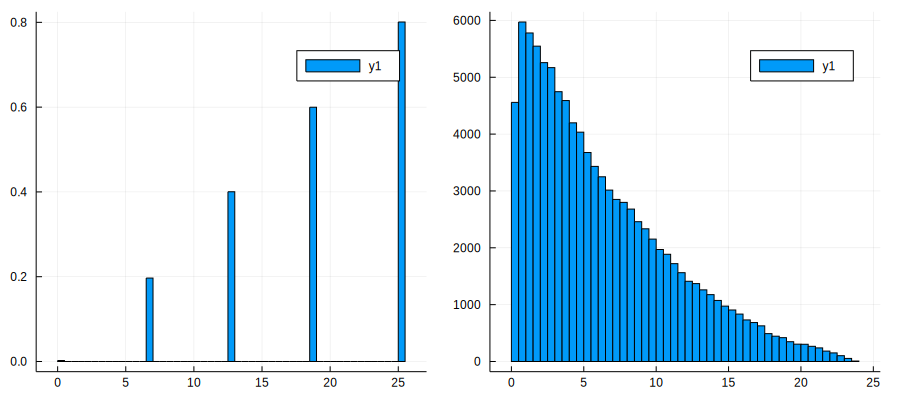

In [26]:
plot(layout=@layout [a b]
    ,size=(900,400),
    histogram(dataset[1,:], bins=100, norm=true),
    histogram(dataset[2,:], bins=100)
    )

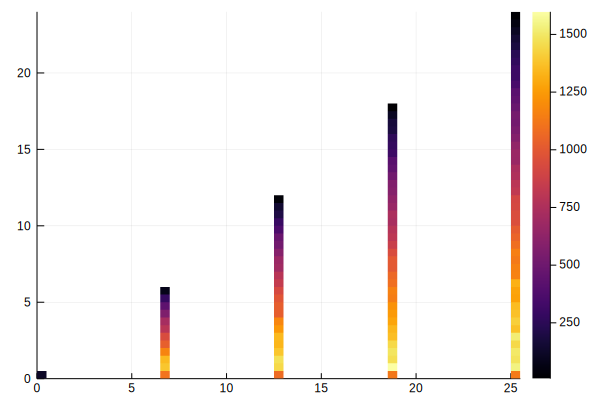

In [27]:
histogram2d(dataset[1,:],dataset[2,:], bins=100)

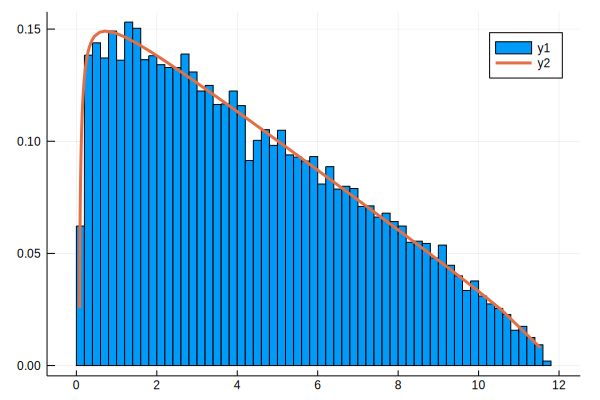

In [28]:
let selected_data = dataset[:,10 .< dataset[1,:] .< 15]
    histogram(selected_data[2,:], bins=100, norm=true)
    si = selected_data[1,1]
    σ1 = min(selected_data[2,:]...)
    σ2 = max(selected_data[2,:]...)
    norm_ = quadgk(σ->g(si,σ), σ1, σ2)[1]
    plot!(σ->g(si,σ)/norm_, σ1, σ2, lw=3)
end

In [10]:
const mp = 0.938;
const mp2 = mp^2;
const Ebeam = 191;
const s0 = mπ2+mp2+2mp*Ebeam;

### $t$-destribution

$$
\rho(t) = N\,e^{\alpha t}, \quad t \in [-1.0, -0.1]
$$
$$
\frac{1}{N} = \int_{-1.0}^{-0.1} e^{\alpha t} \mathrm{d} t= \frac{e^{-0.1\alpha}-e^{-1.0\alpha}}{\alpha}
$$

In [29]:
function randt(α=10)
    t1 = -0.1
    t2 = -1.0
    return log(rand()*(exp(t1*α)-exp(t2*α))+exp(t2*α))/α
end

randt (generic function with 2 methods)

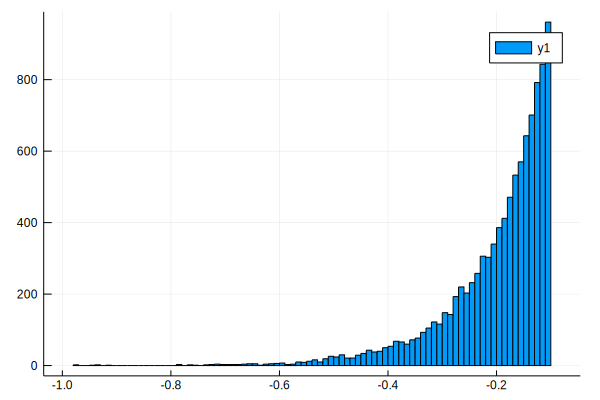

In [30]:
histogram([randt() for i in 1:10000])

In [31]:
tranges(s0,s) = (s+mπ2-(s0+s-mp2)*(s0+mπ2-mp2)/(2s0)) .+ sqrt(λ(s0,s,mp2)*λ(s0,mπ2,mp2))/(2s0) .* [-1,1]

tranges (generic function with 1 method)

In [32]:
tranges(s0,10^2)

2-element Array{Float64,1}:
 -257.1035547879908    
   -0.09522968218701067

### Order: s0, t, s, sigma, cosGJ, phiGJ

In [15]:
randsσ = generate_rand2d(g, 100, 50);

In [16]:
using DelimitedFiles

In [17]:
let dataset = vcat([[s0 randt() randsσ()... 2rand()-1 π*(2rand()-1)] for i in 1:10000]...)
    writedlm("production_MC.txt", dataset)
#     dataset
end

## Test

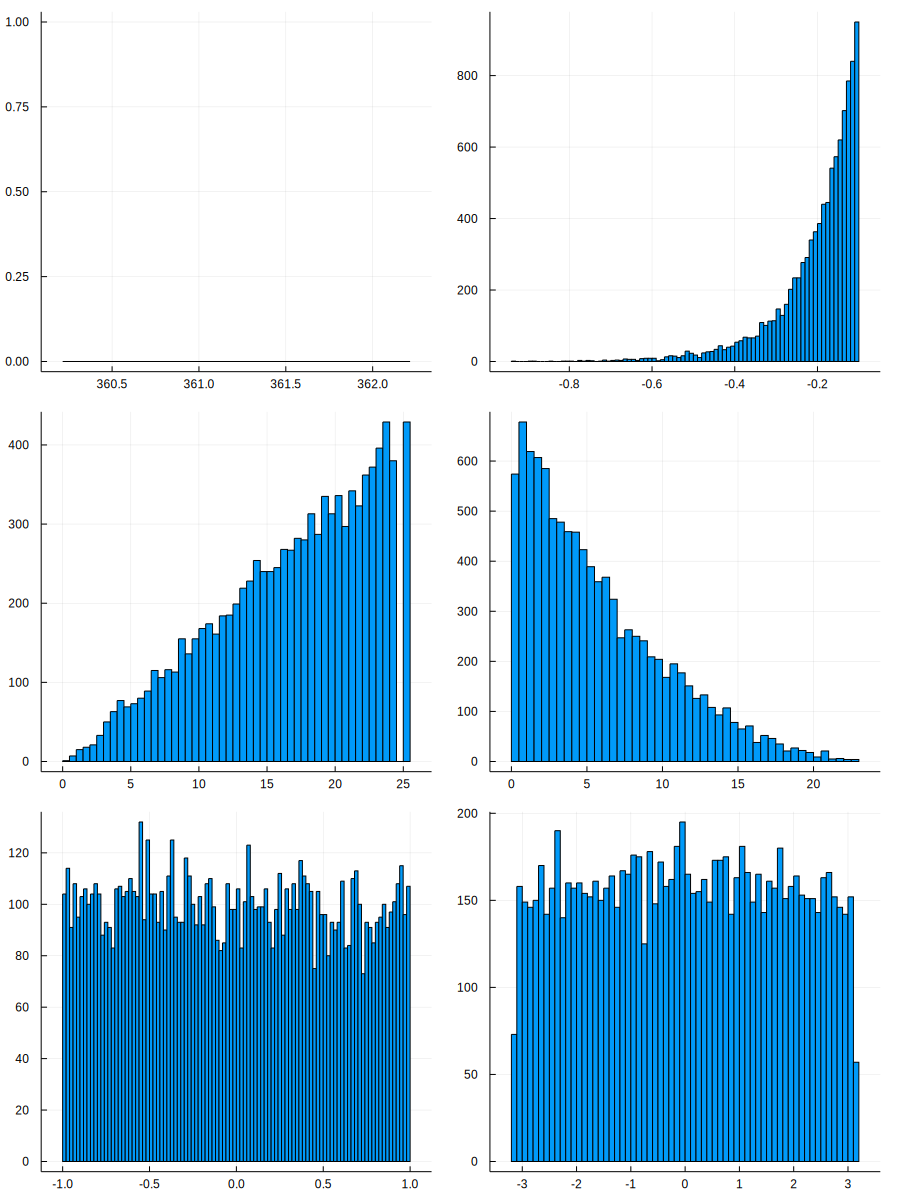

In [24]:
data = readdlm("production_MC.txt");
plot(layout=grid(3,2), size=(900,1200),
    [histogram(data[:,i], bins=100, lab="") for i=1:6]...
)